# VAE

Our VAE implementation will consist solely of fully connected layers. We'll take the `1 x 28 x 28` shape of our input and flatten the features to create an input dimension size of 784. 

In this section you'll define the Encoder and Decoder models, implement the reparametrization trick, forward pass, and loss function to train your first VAE.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np 
import random
import argparse
import pickle 
import os
import math
from PIL import Image

import torch
from torch.nn import init
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data
from torch.utils.data import DataLoader
from torch.utils.data import sampler

from torchvision import transforms
from torchvision.utils import save_image
import torchvision.models as models
import torchvision.transforms as T
import torchvision.datasets as dset

%matplotlib inline

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)  

set_seed(0)

In [ ]:
############################################################################################
#                                  BEGINNING OF YOUR CODE                                  #
############################################################################################
# TODO: Check availability of GPU and set the device accordingly                                 #
device = None
device = torch.device('cuda')
############################################################################################
#                                  END OF YOUR CODE                                  #
############################################################################################

In [ ]:
# Downloading the dataset

batch_size = 128

mnist_train = dset.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



In [ ]:
# Custom Function to show images

def show_images(images):
    images = torch.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

## Define the model parameters

1. Define the `encoder`, `decoder`, `mu_layer`, and `logvar_layer` in the initialization (`__init__` function) of the below class. Use nn.Sequential to define the encoder, and separate Linear layers for the mu and logvar layers. In all of these layers, H will be a hidden dimension you set and will be the same across all encoder and decoder layers. 

**Architecture for the encoder is described below:**


 * `Flatten` (Hint: nn.Flatten)
 * Fully connected layer with input size 784 (`input_size`) and output size H
 * `LeakyReLU` with negative slope of 0.01
 * Fully connected layer with input_size H and output size H
 * `LeakyReLU` with negative slope of 0.01
 
We'll now define the decoder, which will take the latent space representation and generate a reconstructed image. The architecture is as follows: 


 **Architecture for the decoder is described below:**


 * Fully connected layer with input size as the latent size (Z) and output size H
 * `LeakyReLU` with negative slope of 0.01
 * Fully connected layer with input_size H and output size H
 * `LeakyReLU` with negative slope of 0.01
 * Fully connected layer with input_size H and output size H
 * `LeakyReLU` with negative slope of 0.01
 * Fully connected layer with input_size H and output size H
 * `LeakyReLU` with negative slope of 0.01
 * Fully connected layer with input_size H and output size 784 (`input_size`)
 * `Sigmoid`
 * `Unflatten` (nn.Unflatten)


Please do not touch the `forward` function for now. We will come back to it later.

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_size, latent_size=15):
        super(VAE, self).__init__()
        self.input_size = input_size # H*W
        self.latent_size = latent_size # Z
        self.hidden_dim = 150

        self.encoder = None
        self.mu_layer = None
        self.logvar_layer = None
        self.decoder = None

        ############################################################################################
        #                                  BEGINNING OF YOUR CODE                                  #
        ############################################################################################
        ############################################################################################
        # TODO: Implement the fully-connected encoder architecture described in the notebook.      #
        # Specifically, self.encoder should be a network that inputs a batch of input images of    #
        # shape (N, 1, H, W) into a batch of hidden features of shape (N, H_d). Set up             #
        # self.mu_layer and self.logvar_layer to be a pair of linear layers that map the hidden    #
        # features into estimates of the mean and log-variance of the posterior over the latent    #
        # vectors; the mean and log-variance estimates will both be tensors of shape (N, Z).       #
        ############################################################################################
        

        # Define the encoder: A two Linear+ReLU layers neural network.
        self.encoder = nn.Sequential(
          nn.Flatten(),
          nn.Linear(self.input_size, self.hidden_dim),
          nn.LeakyReLU(0.01),
          nn.Linear(self.hidden_dim, self.hidden_dim),
          nn.LeakyReLU(0.01),
        )

        # Define the mu_layer, with input (N, H_d) and output (N, Z)
        self.mu_layer = nn.Linear(self.hidden_dim, self.latent_size)
        # Define the logvar_layer, with input (N, H_d) and output (N, Z)
        self.logvar_layer = nn.Linear(self.hidden_dim, self.latent_size)

        ############################################################################################
        # TODO: Implement the fully-connected decoder architecture described in the notebook.      #
        # Specifically, self.decoder should be a network that inputs a batch of latent vectors of  #
        # shape (N, Z) and outputs a tensor of estimated images of shape (N, 1, H, W).             #
        ############################################################################################
        

        self.decoder = nn.Sequential(
          nn.Linear(self.latent_size, self.hidden_dim),
          nn.LeakyReLU(0.01),
          nn.Linear(self.hidden_dim, self.hidden_dim),
          nn.LeakyReLU(0.01),
          nn.Linear(self.hidden_dim, self.hidden_dim),
          nn.LeakyReLU(0.01),
          nn.Linear(self.hidden_dim, self.hidden_dim),
          nn.LeakyReLU(0.01),
          nn.Linear(self.hidden_dim, self.input_size),
          nn.Sigmoid(),
          nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
        )

        ############################################################################################
        #                                      END OF YOUR CODE                                    #
        ############################################################################################


    def forward(self, x):
        """
        Performs forward pass through FC-VAE model by passing image through 
        encoder, reparametrize trick, and decoder models
    
        Inputs:
        - x: Batch of input images of shape (N, 1, H, W)
        
        Returns:
        - x_hat: Reconstruced input data of shape (N,1,H,W)
        - mu: Matrix representing estimated posterior mu (N, Z), with Z latent space dimension
        - logvar: Matrix representing estimataed variance in log-space (N, Z), with Z latent space dimension
        """
        x_hat = None
        mu = None
        logvar = None

        ############################################################################################
        #                                  BEGINNING OF YOUR CODE                                  #
        ############################################################################################
        ############################################################################################
        # TODO: Implement the forward pass by following these steps                                #
        # (1) Pass the input batch through the encoder model, pass the output to mu_layer and      # 
        # logvar_layer to get the posterior mu and logvariance                                     #
        # (2) Reparametrize to compute  the latent vector z                                        #
        # (3) Pass z through the decoder to resconstruct x                                         #
        ############################################################################################
      
        # Pass input images "x" to the encoder. Output shape is: (N, H_d)
        encoder_out = self.encoder(x)

        # Get the posterior mu from the encoder's output. Its shape is: (N, Z)
        mu = self.mu_layer(encoder_out)
        # Get the posterior logvariance from the encoder's output. Its shape is: (N, Z)
        logvar = self.logvar_layer(encoder_out)

        # Reparametrize to compute the latent vector "z", of shape (N, Z)
        z = reparametrize(mu, logvar)

        # Pass "z" through the decoder to resconstruct "x", the "x_hat".
        x_hat = self.decoder(z)

        ############################################################################################
        #                                      END OF YOUR CODE                                    #
        ############################################################################################
        return x_hat, mu, logvar

## Reparameterization Trick

Now we'll apply a reparametrization trick in order to estimate the posterior $z$ during our forward pass, given the $\mu$ and $\sigma^2$ estimated by the encoder. A simple way to do this could be to simply generate a normal distribution centered at our  $\mu$ and having a std corresponding to our $\sigma^2$. However, we would have to backpropogate through this random sampling that is not differentiable. Instead, we sample initial random data $\epsilon$ from a fixed distrubtion, and compute $z$ as a function of ($\epsilon$, $\sigma^2$, $\mu$). Specifically:

$z = \mu + \sigma\epsilon$

We can easily find the partial derivatives w.r.t $\mu$ and $\sigma^2$ and backpropagate through $z$. If $\epsilon = \mathcal{N} (0,1)$, then its easy to verify that the result of our forward pass calculation will be a distribution centered at $\mu$ with variance $\sigma^2$.

Implement the `reparametrization` function.

In [ ]:
def reparametrize(mu, logvar):
    """
    Differentiably sample random Gaussian data with specified mean and variance using the
    reparameterization trick.
    Inputs:
    - mu: Tensor of shape (N, Z) giving means
    - logvar: Tensor of shape (N, Z) giving log-variances
    Returns: 
    - z: Estimated latent vector of shape (N, Z), where z[i, j] is a random value sampled from a Gaussian with
         mean mu[i, j] and log-variance logvar[i, j].
    """
    z = None

    ################################################################################################
    #                                  BEGINNING OF YOUR CODE                                      #
    ################################################################################################
    ################################################################################################
    # TODO: Reparametrize by initializing epsilon as a normal distribution and scaling by          #
    # posterior mu and sigma to estimate z                                                         #
    ################################################################################################
    

    # Convert the "log of the variance" to "sigma" (standard deviation).
    sigma = torch.sqrt(torch.exp(logvar))

    # Compute 'z'.
    # Epsilon is a Tensor that contains random samples from a standard normal
    # distribution (mu=0, std=1)
    z = sigma * torch.randn_like(mu) + mu


    ################################################################################################
    #                              END OF YOUR CODE                                                #
    ################################################################################################
    return z

## Define the forward pass in the `VAE` class

Go back to the cell above the Reparameterization trick header, which contains the definition of the `VAE` class.

Implement the forward pass in the `forward` function, and run the cell.

## Loss function

The loss function for VAEs contains two terms: A reconstruction loss term (left) and KL divergence term (right). 

$-E_{Z~q_{\phi}(z|x)}[log p_{\theta}(x|z)] + D_{KL}(q_{\phi}(z|x), p(z)))$

Note that this is the negative of the variational lowerbound -this ensures that when we are minimizing this loss term, we're maximizing the variational lowerbound. The reconstruction loss term can be computed by simply using the binary cross entropy loss between the original input pixels and the output pixels of our decoder (Hint: `nn.functional.binary_cross_entropy`). The KL divergence term works to force the latent space distribution to be close to a prior distribution (we're using a standard normal gaussian as our prior).

To help you out, we've derived an unvectorized form of the KL divergence term for you.
Suppose that $q_\phi(z|x)$ is a $Z$-dimensional diagonal Gaussian with mean $\mu_{z|x}$ of shape $(Z,)$ and standard deviation $\sigma_{z|x}$ of shape $(Z,)$, and that $p(z)$ is a $Z$-dimensional Gaussian with zero mean and unit variance. Then we can write the KL divergence term as:

$D_{KL}(q_{\phi}(z|x), p(z))) = -\frac{1}{2} \sum_{j=1}^{J} (1 + log(\sigma_{z|x}^2)_{j} - (\mu_{z|x})^2_{j} - (\sigma_{z|x})^2_{j}$)

Implement a vectorized version of this loss that operates on minibatches.
You should average the loss across samples in the minibatch.

In [ ]:
def loss_function(x_hat, x, mu, logvar):
    """
    Computes the negative variational lower bound loss term of the VAE (refer to formulation in notebook).
    Inputs:
    - x_hat: Reconstruced input data of shape (N, 1, H, W)
    - x: Input data for this timestep of shape (N, 1, H, W)
    - mu: Matrix representing estimated posterior mu (N, Z), with Z latent space dimension
    - logvar: Matrix representing estimated variance in log-space (N, Z), with Z latent space dimension
    
    Returns:
    - loss: Tensor containing the scalar loss for the negative variational lowerbound
    """
    loss = None
    
    ################################################################################################
    #                                  BEGINNING OF YOUR CODE                                      #
    ################################################################################################
    ################################################################################################
    # TODO: Compute negative variational lowerbound loss as described in the notebook.             #
    # Note that the log variance is provided as the input to your function. Interpret the hints    #
    # above accordingly.
    ################################################################################################
    

    # Get the minibatch size
    N = mu.shape[0]

    # Compute the reconstruction loss term, using Binary Cross Entropy (BCE) loss.
    # The "BCE loss" have to be adapted to the "reconstruction loss" (Expectation) by:
    # - Changing the reduction mode from 'mean' (default) to 'sum' (used in the Expectation).
    # - The input to the BCE is 'x_hat' and the target is 'x'. This can be done because we are
    # operating on MNIST dataset, where each pixel is either 0 or 1.
    # Note that the minus sign is handled by the BCE loss itself.
    rec_term = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')

    # Compute the KL divergence term (kldiv_term).
    kldiv_term = 1 + logvar - mu**2 - torch.exp(logvar)
    kldiv_term = -0.5 * kldiv_term.sum()

    # Final loss is the sum of "reconstruction loss term" and "KL divergence term".
    loss = rec_term + kldiv_term

    # Average the loss across samples in the minibatch.
    loss /= N
    
    ################################################################################################
    #                            END OF YOUR CODE                                                  #
    ################################################################################################
    return loss

## Train the VAE

In [ ]:
# Leave this cell untouched
def train_vae(epoch, model, train_loader):
    """
    Train the VAE!

    Inputs:
    - epoch: Current epoch number 
    - model: VAE model object
    - train_loader: PyTorch Dataloader object that contains our training data
    """
    model.train()
    train_loss = 0
    num_classes = 10
    loss = None
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
    print('Train Epoch: {} \tLoss: {:.6f}'.format(
        epoch, loss.data))

In [ ]:
# Leave this cell untouched

set_seed(0)

num_epochs = 10
latent_size = 15
input_size = 28*28


vae_model = VAE(input_size, latent_size=latent_size)
vae_model.to(device)
for epoch in range(0, num_epochs):
  train_vae(epoch, vae_model, loader_train)

Train Epoch: 0 	Loss: 184.344604
Train Epoch: 1 	Loss: 140.348877
Train Epoch: 2 	Loss: 134.319748
Train Epoch: 3 	Loss: 132.025558
Train Epoch: 4 	Loss: 121.897018
Train Epoch: 5 	Loss: 127.866997
Train Epoch: 6 	Loss: 123.495796
Train Epoch: 7 	Loss: 123.404282
Train Epoch: 8 	Loss: 115.670624
Train Epoch: 9 	Loss: 116.173759


## Question 1

Report the final training loss displayed after training the VAE, as displayed in the cell.(Select the closest answer)

1. 116 (Correct Answer)
2. 103
3. 128
4. 90 

# Adversarial Autoencoder(AAE)

In the following problem we will implement an Adversarial Autoencoder(AAE) to map MNIST images into latent representations that follow a Gaussian distribution. Please refer to the lecture to understand the idea behind AAE.



In [ ]:
import math
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import random
import os
import numpy as np
import torchvision.transforms as T
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)  

set_seed(0)

In [ ]:
def show_images(images):
    images = torch.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(math.ceil(math.sqrt(images.shape[0])))
    sqrtimg = int(math.ceil(math.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

In [ ]:
dtype = torch.float

# set device

device = torch.device("cuda:0")

download MNIST if not exist


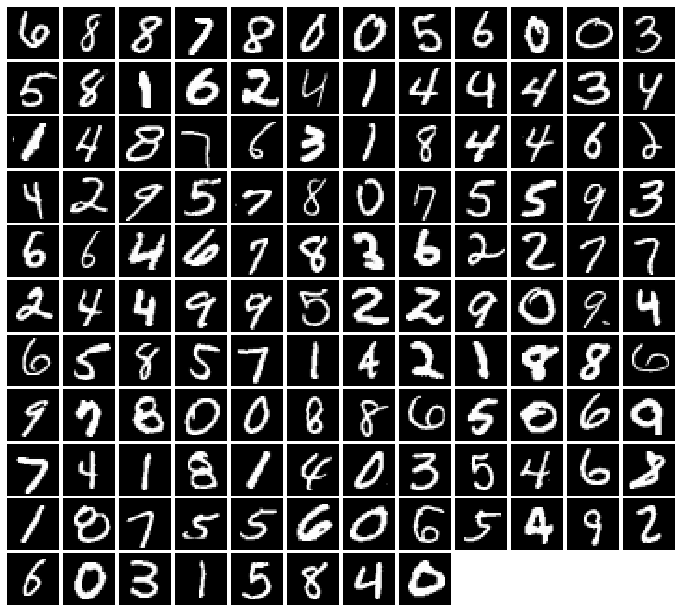

In [ ]:
# let us load the input images from the dataset and visualize some images!

batch_size = 128
NOISE_DIM = 96

print('download MNIST if not exist')

mnist_train = dset.MNIST('./MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)


imgs = loader_train.__iter__().next()[0].view(batch_size, 784)
show_images(imgs)

## Generating Random Noise

The first step is to generate gaussian noise with mean 0 and variance 25 with shape `[batch_size, noise_dim]`. This noise will be used to draw samples of  vectors with the desired prior distribution to which we want to map our latent representations.

Hint: use `torch.randn`.

Implement `sample_gaussian_noise` below.

In [ ]:
def sample_gaussian_noise(batch_size, noise_dim, dtype=torch.float, device='cpu'):
  """
  Generate a PyTorch Tensor of uniform random noise.

  Input:
  - batch_size: Integer giving the batch size of noise to generate.
  - noise_dim: Integer giving the dimension of noise to generate.
  
  Output:
  - A PyTorch Tensor of shape (batch_size, noise_dim) containing gaussian noise with mean 0 and variance 25.
  """
  noise = None
  ##############################################################################
  #                           BEGINNING OF YOUR CODE                           #
  ##############################################################################
  ##############################################################################
  # TODO: Implement sample_noise.                                              #
  ##############################################################################
 
  # The generated noise values (from gaussian distribution) must have mean 0 
  # and variance 25.
  # However, "torch.randn" generates noise with variance 1.
  # For that, we must multiply the noise with appropiate constant which is the 
  # square root of the desired variance.
 
  noise = torch.randn((batch_size, noise_dim), device=device) * 5

  ##############################################################################
  #                              END OF YOUR CODE                              #
  ##############################################################################

  return noise

## Encoder, Decoder and Discriminator

**The definitions of these functions are provided to you.**

They are explained below:

### Encoder

The architecture is:
 * Fully connected layer with input size 784 and output size 256
 * `LeakyReLU with alpha 0.01`
 * Fully connected layer with input size 256 and output size 256
 * `LeakyReLU with alpha 0.01`
 * Fully connected layer with input size 256 and output size is the `latent_size`.
  
The output of the discriminator is of shape `[batch_size, latent size]`, and contains the latent representations of each of the `batch_size` inputs.

### Decoder

The architecture is:
 * Fully connected layer from `latent_size` to 1024
 * `ReLU`
 * Fully connected layer with input size 1024 and output size 1024
 * `ReLU`
 * Fully connected layer with input size 1024 and output size 784
 * `Sigmoid` (to clip the image to be in the range of [0,1])

 This outputs a tensor of shape of `[batch_size, 784]` that is the   reconstructed images in the batch.

### Discriminator

The architecture is:
 * Fully connected layer from `latent_size` to 256
 * `LeakyReLU with alpha 0.01`
 * Fully connected layer with input size 256 and output size 256 
 * `LeakyReLU with alpha 0.01`
 * Fully connected layer with input size 256 and output size 1

 This outputs a tensor of shape of `[batch_size, 1]` that is indication whether the latent noise input is coming for the real prior distribuition or not.

In [ ]:
LATENT_SIZE = 24 # default noise dimension

##############################################################################
#                           BEGINNING OF YOUR CODE                           #
##############################################################################
##############################################################################

def encoder(latent_size=LATENT_SIZE):
  ##############################################################################
  #TODO: Build and return a PyTorch nn.Sequential model implementing the architecture in the notebook.
  ##############################################################################

  model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),  # 1st Fully-Connected layer.
    nn.LeakyReLU(0.01),
    nn.Linear(256, 256),  # 2nd Fully-Connected layer.
    nn.LeakyReLU(0.01),
    nn.Linear(256, latent_size)     # 3rd Fully-Connected layer.
  )

  return model


def decoder(latent_size=LATENT_SIZE):
  ##############################################################################
  #TODO: Build and return a PyTorch nn.Sequential model implementing the 
  # architecture in the notebook.
  ##############################################################################
  model = nn.Sequential(
    nn.Linear(latent_size, 1024),  # 1st Fully-Connected layer.
    nn.ReLU(),
    nn.Linear(1024, 1024),       # 2nd Fully-Connected layer.
    nn.ReLU(),
    nn.Linear(1024, 784),        # 3rd Fully-Connected layer.
    nn.Sigmoid()
  )

  return model  


def discriminator(latent_size=LATENT_SIZE):
  ##############################################################################
  #TODO: Build and return a PyTorch nn.Sequential model implementing the 
  # architecture in the notebook.
  ##############################################################################
  model = nn.Sequential(
    nn.Linear(latent_size, 256),  # 1st Fully-Connected layer.
    nn.LeakyReLU(0.1),
    nn.Linear(256, 256),       # 2nd Fully-Connected layer.
    nn.LeakyReLU(0.1),
    nn.Linear(256, 1)        # 3rd Fully-Connected layer.
  )

  return model  

##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################

## Loss functions

We will compute the generator and discriminator loss. 

The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
We will be *minimizing* these losses. We have already implemented the functions to compute these losses. Please go trhough them carefully.



In [ ]:
def discriminator_loss(logits_real, logits_fake):
  """
  Computes the discriminator loss described above.
  
  Inputs:
  - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
  - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
  
  Returns:
  - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
  """
  loss = None
  
  # For the discriminator (D), the true target (y = 1) corresponds to "real" vectors.
  # Thus, for the scores of real vectors, the target is always 1 (a vector).
  real_labels = torch.ones_like(logits_real, device=device)
  # Compute the BCE for the scores of the real vectors.
  # Note that the BCE itself uses the Expectation formula (in addition, an average is
  # taken throughout the losses, not a sum [as requested in this assignment]).
  real_loss = F.binary_cross_entropy_with_logits(logits_real, real_labels)

  # For D, the false target (y = 0) corresponds to "fake" vectors.
  # Thus, for the scores of fake vectors, the target is always 0 (a vector).
  fake_labels = torch.zeros_like(logits_fake, device=device)
  # As for the real scores, compute the BCE loss for the fake vectors.
  fake_loss = F.binary_cross_entropy_with_logits(logits_fake, fake_labels)

  # Sum "real" and "fake" losses.
  # That is, BCE has already taken into account the "negated equation" form,
  # the "log" (in the Expectation) and the "mean" (insetead on the "sum").
  loss = real_loss + fake_loss

  return loss

def generator_loss(logits_fake):
  """
  Computes the generator loss described above.

  Inputs:
  - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
  
  Returns:
  - loss: PyTorch Tensor containing the (scalar) loss for the generator.
  """
  loss = None
  
  # For the generator (G), the true target (y = 1) corresponds to "fake" vectors.
  # Thus, for the scores of fake vectors, the target is always 1 (a vector).
  fake_labels = torch.ones_like(logits_fake, device=device)
  # Compute the BCE for the scores of the fake vectors.
  fake_loss = F.binary_cross_entropy_with_logits(logits_fake, fake_labels)

  # The generator loss is "fake_loss".
  # That is, BCE has already taken into account the "negated equation" form,
  # the "log" (in the Expectation) and the "mean" (insetead on the "sum").
  loss = fake_loss

  return loss

## Training

Complete the code below for the main training loop of the Adverserial Autoencoder.

In [ ]:
def run_aae(En, De, Ds, En_solver, De_solver, Ds_solver, Gn_solver, show_every=250, 
              batch_size=128, latent_size=LATENT_SIZE, num_epochs=5):
  """
  Train an AAA!
  
  Inputs:
  - En, De, Ds: PyTorch models for the encoder, decoder and discriminator
  - En_solver, De_solver, Ds_solver, Gn_solver: torch.optim Optimizers to use for training the
    Enoder, Decoder, Discriminator and Generator(ie the encoder when it is used as a generator).
  - show_every: Show samples after every show_every iterations.
  - batch_size: Batch size to use for training.
  - latent_size: Dimension of the latent representation of the inputs.
  - num_epochs: Number of epochs over the training dataset to use for training.
  """
  iter_count = 0
  for epoch in range(num_epochs):
    for x, _ in loader_train:
      if len(x) != batch_size:
        continue

      ##############################################################################
      #                           BEGINNING OF YOUR CODE                           #
      ##############################################################################
      ##############################################################################

      En_solver.zero_grad()
      De_solver.zero_grad()
      real_data = x.view(-1, 784).to(device)

      ##############################################################################
      #TODO: Compute the latent representations and the reconstructed images using 
      # the encoder, deocder
      ##############################################################################

      latent_sample = En(real_data)
      recon_data = De(latent_sample)

      ##############################################################################
      #TODO: Compute the reconstruction loss between the real data and the 
      # reconsructed data using binary cross entropy with reduction as 'sum'
      ##############################################################################      

      recon_loss = F.binary_cross_entropy(recon_data, real_data, reduction='sum')

      ##############################################################################
      #TODO: Backpropagate the recon_loss and do an optimization step on the encoder 
      # and decoder solvers
      ##############################################################################   

      recon_loss.backward()
      En_solver.step()
      De_solver.step()

      En.eval()

      ##############################################################################
      # Generating random latent samples with desired gaussian distribution
      ##############################################################################  
      real_latent = sample_gaussian_noise(batch_size, latent_size, dtype=real_data.dtype, device=real_data.device)

      ##############################################################################
      #TODO: Generate fake latent samples from the real data using the encoder
      ############################################################################## 
      fake_latent = En(real_data)

      ##############################################################################
      #TODO: Compute the logits corresponding to the real latent vectors and the fake 
      # latent vectors using the discriminator
      ############################################################################## 
      logits_real_latent = Ds(real_latent)
      logits_fake_latent = Ds(fake_latent)

      ##############################################################################
      #TODO: Compute the discriminator loss between the logits corresponding to the 
      # real and fake latents using the discriminator loss function defined before
      ############################################################################## 

      ds_total_loss = discriminator_loss(logits_real_latent, logits_fake_latent)

      ##############################################################################
      #TODO: Backpropagate the discriminator loss and do an optimization step on the 
      # discriminator solver      
      ############################################################################## 

      ds_total_loss.backward()
      Ds_solver.step()

      ##############################################################################
      #                              END OF YOUR CODE                              #
      ##############################################################################

      En.train()
     
      ##############################################################################
      # Training the encoder based on the generator loss   
      ############################################################################## 

      latent_sample_fake = En(real_data)
      gen_logits_fake = Ds(latent_sample_fake)
      g_loss = generator_loss(gen_logits_fake)

      g_loss.backward()
      Gn_solver.step()
  
      if (iter_count % show_every == 0):
        print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,ds_total_loss.item(),g_loss.item()))
        imgs_numpy = recon_data.data.cpu()#.numpy()
        show_images(imgs_numpy[0:16])
        plt.show()
        print()
      iter_count += 1
    if epoch == num_epochs - 1:
      show_images(imgs_numpy[0:16])


Now run the cell below to train the Adverserial Autoencoder! 



Iter: 0, D: 1.339, G:0.6863


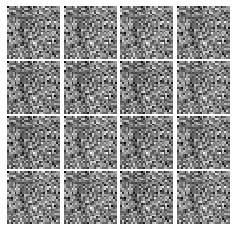


Iter: 250, D: 0.7193, G:1.262


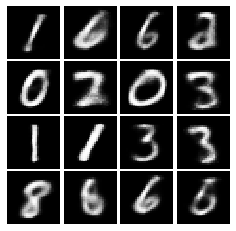


Iter: 500, D: 3.753, G:0.5981


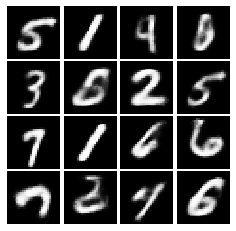


Iter: 750, D: 2.533, G:2.607


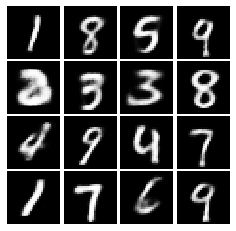


Iter: 1000, D: 6.346, G:3.262


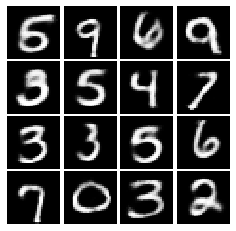


Iter: 1250, D: 19.36, G:1.236


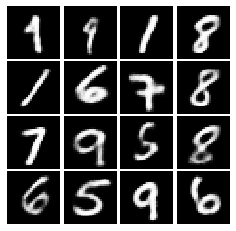


Iter: 1500, D: 0.5075, G:26.31


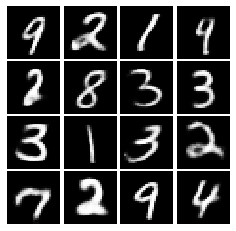


Iter: 1750, D: 9.837, G:1.394


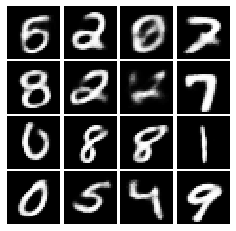


Iter: 2000, D: 1.904, G:26.96


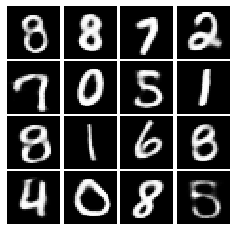


Iter: 2250, D: 15.32, G:2.432


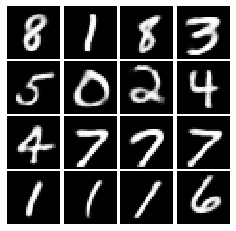

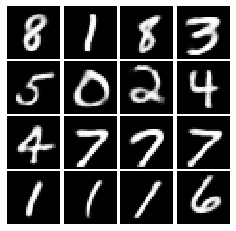

In [ ]:
# Leave this cell untouched

set_seed(0)

# Make the discriminator
En = encoder().to(device)

# Make the discriminator
De = decoder().to(device)

# Make the generator
Ds = discriminator().to(device)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
En_solver = optim.Adam(En.parameters(), lr=1e-3, betas=(0.5, 0.999))
De_solver = optim.Adam(De.parameters(), lr=1e-3, betas=(0.5, 0.999))
Ds_solver = optim.Adam(Ds.parameters(), lr=1e-3, betas=(0.5, 0.999))
Gn_solver = optim.Adam(En.parameters(), lr=1e-3, betas=(0.5, 0.999))

# Run it!
run_aae(En, De, Ds, En_solver, De_solver, Ds_solver, Gn_solver)

## Question 2

What is the discriminator error after 2250 iterations displayed in the cell?

1. 0-10 
2. 11-20 (Correct Answer)
3. 21-30
4. 31-40

## Question 3

What is the generator error after 2250 iterations displayed in the cell? 

1. 0.5-0.99 
2. 1-1.99
3. 3-3.99
4. 2-2.99  (Correct Answer)
